In [1]:
import sys
sys.path.append("..")
from IPython.display import display

In [2]:
import numpy as np
import logging
import pickle
import time
%matplotlib inline
import matplotlib.pyplot as plt
import importlib 
plt.rcParams["figure.figsize"] = (8,8)

In [3]:
from scripts import reclusterTree
from scripts import linkageList
from scripts import heatClustermap
from scripts import Tree1D
from scripts import likelihood
from scripts import reclustGreedyLH
from scripts import beamSearch
from scripts import beamSearch_list

In [4]:
# Reload filles after changes
importlib.reload(reclusterTree)
importlib.reload(linkageList)
importlib.reload(heatClustermap)
importlib.reload(Tree1D)
importlib.reload(likelihood)
importlib.reload(reclustGreedyLH)
importlib.reload(beamSearch)
importlib.reload(beamSearch_list)

<module 'scripts.beamSearch_list' from '/Users/sebastian/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/beamSearch_list.py'>

In [5]:
# Data dir
input_dir= 'data/'
# input_dir ="../ToyJetsShower/data/"

In [6]:
input_jet = 'tree_13_truth'
# input_jet = 'tree_10_truth'

In [7]:
with open(input_dir+ str(input_jet) + '.pkl', "rb") as fd: 
    truth_jet = pickle.load(fd, encoding='latin-1')[0]

jet_name = ('_').join(input_jet.split('_')[-3:-1])
truth_jet["name"]=jet_name
truth_jet["algorithm"]="truth"

display(truth_jet["name"])

'tree_13'

In [8]:
# Fill list with log likelihood of truth jet
likelihood.enrich_jet_logLH(truth_jet)

In [9]:
# Number of jet constituents
linkageList.runTraverse_jet(truth_jet)
len(truth_jet["outers_list"])

10

In [10]:
# Recluster jet
recluster = False
if recluster:
    reclusterKt = reclusterTree.recluster(truth_jet, alpha=1)
    reclusterAntikt = reclusterTree.recluster(truth_jet, alpha=-1)
    reclusterCA = reclusterTree.recluster(truth_jet, alpha=0)

In [11]:
# Load reclustered jets
with open(input_dir+ str(truth_jet["name"])+'_1' + '.pkl', "rb") as fd: reclusterKt = pickle.load(fd, encoding='latin-1')
with open(input_dir+ str(truth_jet["name"])+'_-1' + '.pkl', "rb") as fd: reclusterAntikt = pickle.load(fd, encoding='latin-1')
with open(input_dir+ str(truth_jet["name"])+'_0' + '.pkl', "rb") as fd: reclusterCA = pickle.load(fd, encoding='latin-1')

# LIKELIHOOD BASED ALGORITHMS

## BEAM SEARCH

We implement a beam seach algorithm to find the tree that maximizes the log likelihood, given a certain beam size
beamSearch_jets is a sorted list of all the latent path that give the best total log likelihood, with size N_best.
beamSearch_jets[0] returns the jet with the greatest likelihood

In [12]:
# Global variables
beam_Size = 45
Nbest = 45

In [13]:
start_time = time.time() 

beamSearch_jets = beamSearch.recluster( 
    truth_jet, 
    beamSize = beam_Size,
    delta_min =  truth_jet["pt_cut"],
    lam = truth_jet["Lambda"],
    N_best = Nbest,
)

elapsed_time = time.time()-start_time

In [14]:
print("Generation time for beam size of",beam_Size ,"= ",elapsed_time/60, " minutes")
print("Per beam average generation time =  ", elapsed_time/beam_Size," seconds")

Generation time for beam size of 45 =  0.03574793338775635  minutes
Per beam average generation time =   0.04766391118367513  seconds


In [15]:
beamSearch_jets[0]["logLH"]

array([-1.98505843, -2.14269114, -0.30674982, -1.97229087, -0.46854436,
       -1.89435005, -2.16956115, -2.7541585 , -2.13510752])

In [16]:
np.sum(beamSearch_jets[0]["logLH"])

-15.828511834144592

### Beam Search jet visualizations

Beam Search LH JET


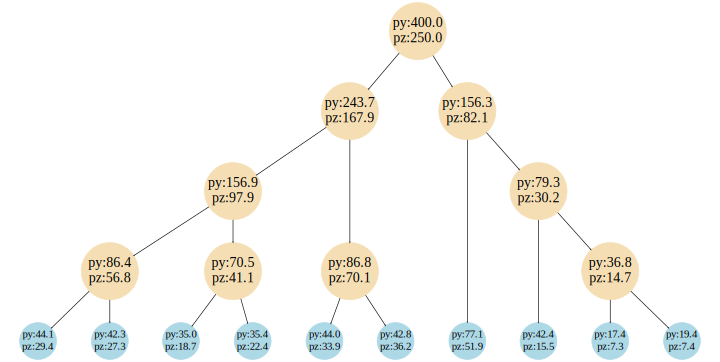

In [17]:
print('Beam Search LH JET')

tree = Tree1D.plotBinaryTree(
    beamSearch_jets[0],
    label=True,
    figFormat = "png",
)
tree.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
# tree.render(filename="plots/1DTreeOnly/figBeamSize50_jet10")
display(tree)

2019-08-14 15:42:45,247:INFO::alpha row: beamSearch -- alpha column: beamSearch


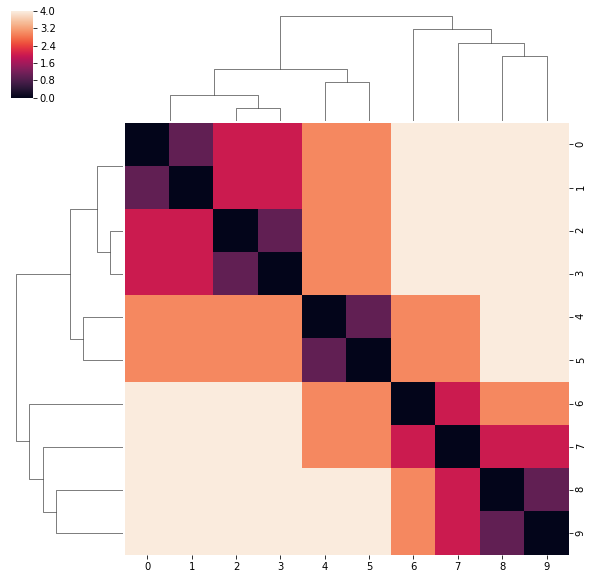

In [18]:
heatClustermap.heat_dendrogram(
    beamSearch_jet = beamSearch_jets[0],
    beamSize = beam_Size,
    N_best = Nbest,
    full_path=False, 
    FigName=None)

### Beam Search jet vs truth jet comparison

Leaves ordered according to truth jet - Beam Search jet with greatest LH (top) vs TRUTH (bottom) trees


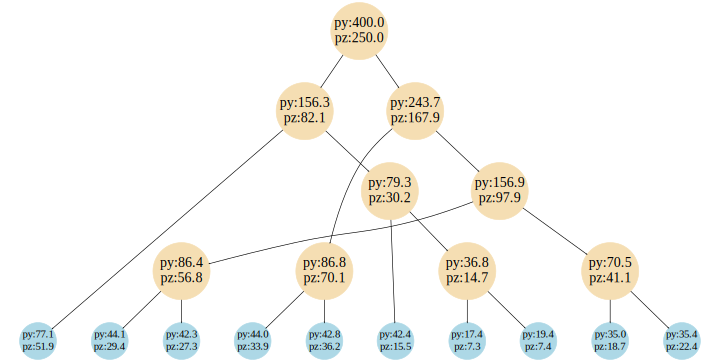

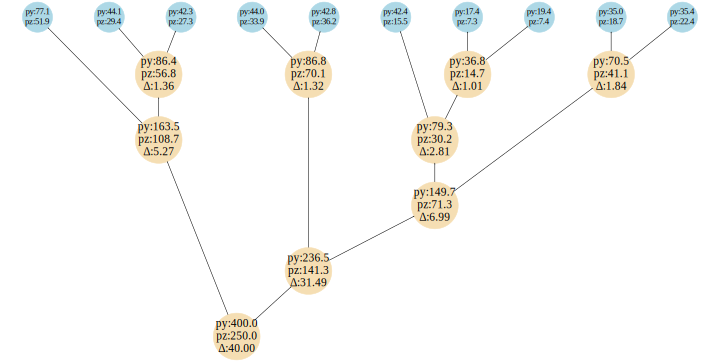

In [19]:
print("Leaves ordered according to truth jet - Beam Search jet with greatest LH (top) vs TRUTH (bottom) trees")
tree1, tree2 = Tree1D.visualizeTreePair(
    beamSearch_jets[0],
    truth_jet,
    truthOrder = True, 
    label=True,
)
tree1.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
tree2.attr(rankdir='BT', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
display(tree1)
display(tree2)

Leaves ordered according to ANTIKT jet - Beam Search (top) vs ANTIKY (bottom) trees


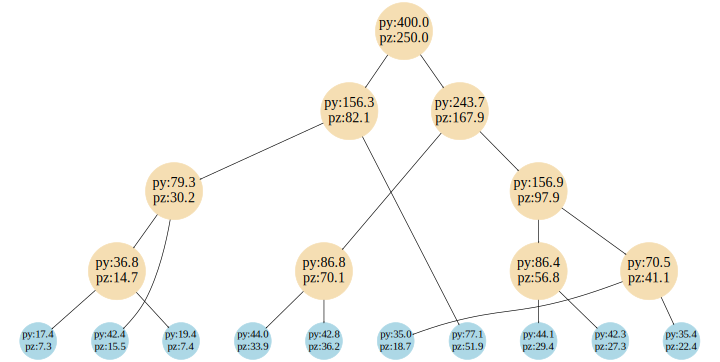

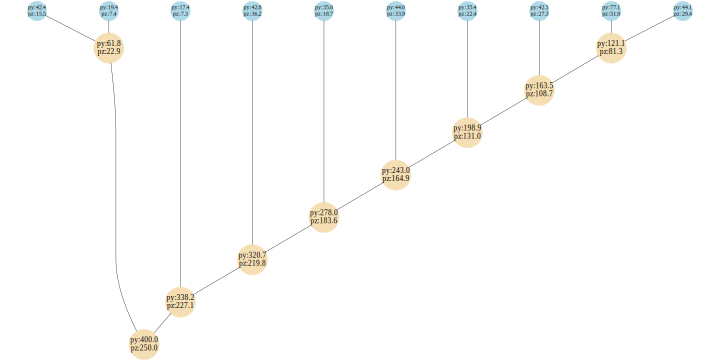

In [20]:
print("Leaves ordered according to ANTIKT jet - Beam Search (top) vs ANTIKY (bottom) trees")
tree1, tree2 = Tree1D.visualizeTreePair(
    reclusterCA,
    beamSearch_jets[0],
    truthOrder = False,
    label = True,
    alpha_jet1 =  -1,
    beamSize = beam_Size, 
    N_best = Nbest,
)
tree1.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
tree2.attr(rankdir='BT', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
display(tree1)
display(tree2)

2019-08-14 15:42:55,567:INFO::alpha row: beamSearch -- alpha column: truth


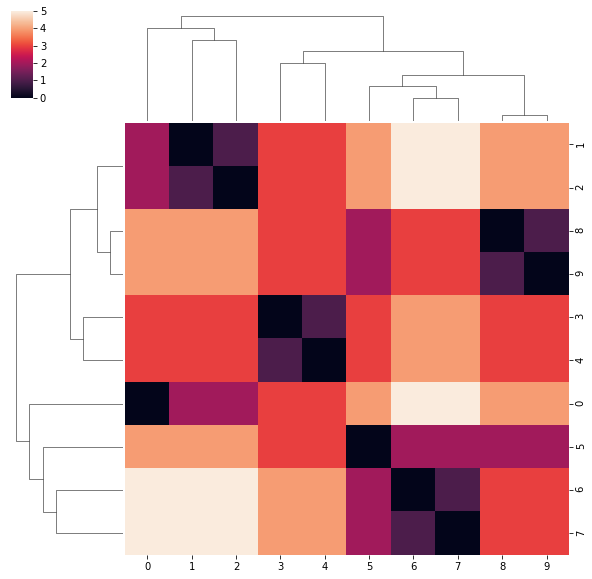

In [21]:
heatClustermap.heat_dendrogram(
    truthJet = truth_jet,
    beamSearch_jet = beamSearch_jets[0],
    full_path=False, 
    FigName=None,
)

2019-08-14 15:42:57,518:INFO::(Truth jet - recluster jet1) heat data


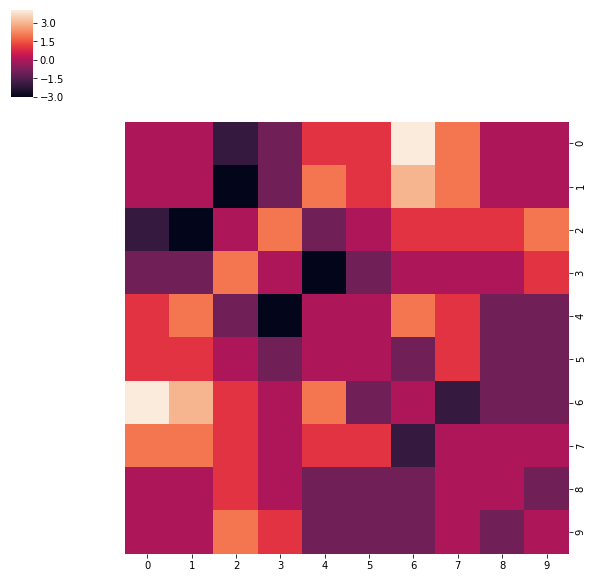

In [22]:
# outFilename="plots/heatClustermap/figDiffTruthBeamSize50_singlepath_jet10.jpg"
heatClustermap.dendrogramDiff(
    truthJet  = truth_jet,
    recluster_jet1 = beamSearch_jets[0],
    full_path=False, 
    FigName=None,
)

### Find latent path that gives the closest log likelihood to the truth jet: 

In [23]:
truth_logLH = np.sum(truth_jet["logLH"]) #with integral
display(truth_logLH)

-16.83590602874756

In [24]:
def closest_logLHjet(in_beamSearch_jets, truth_jet):
    
    truth_logLH = np.sum(truth_jet["logLH"])
    path_logLH_diff = []
    
    for j,jet in enumerate(in_beamSearch_jets):
        path_logLH_diff.append([j, np.absolute(np.sum(in_beamSearch_jets[j]["logLH"]) - truth_logLH)])
    
    logLH_diff = sorted(path_logLH_diff, key=lambda x:x[1])

    return logLH_diff[0]

In [25]:
logLH_diff = closest_logLHjet(beamSearch_jets, truth_jet)
display(logLH_diff)

[2, 0.6900757551193237]

Beam Search jet with closest log LH to truth jet comaprison
Leaves ordered according to truth jet - Beam Search LH (top) vs TRUTH (bottom) trees


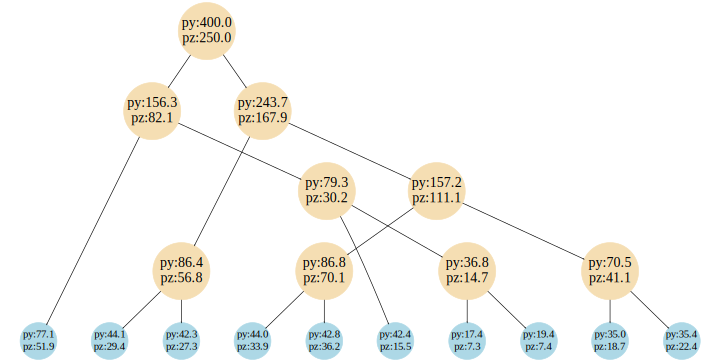

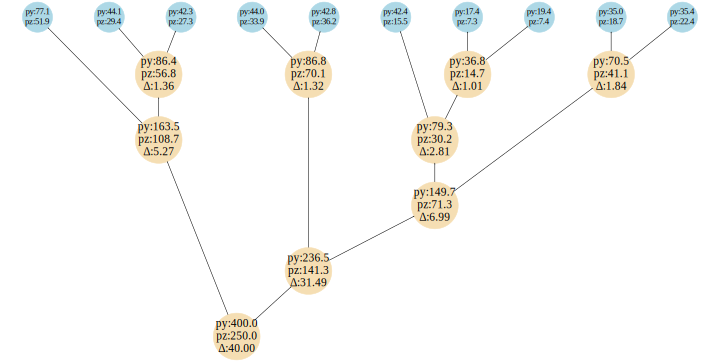

In [26]:
print("Beam Search jet with closest log LH to truth jet comaprison")
print("Leaves ordered according to truth jet - Beam Search LH (top) vs TRUTH (bottom) trees")
tree1, tree2 = Tree1D.visualizeTreePair(
    beamSearch_jets[logLH_diff[0]],
    truth_jet,
    truthOrder = True, 
    label = True,
    beamSize = beam_Size,
    N_best = Nbest,
)
tree1.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
tree2.attr(rankdir='BT', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
display(tree1)
display(tree2)

2019-08-14 15:43:02,085:INFO::(Truth jet - recluster jet1) heat data


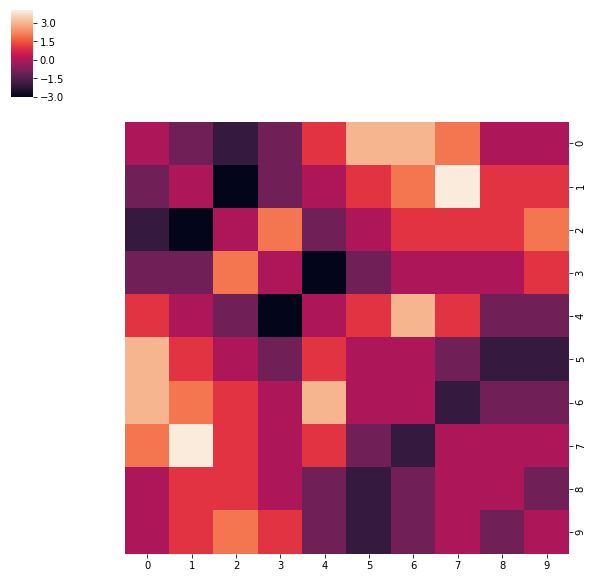

In [27]:
heatClustermap.dendrogramDiff(
    truthJet  = truth_jet,
    recluster_jet1= beamSearch_jets[logLH_diff[0]],
    full_path=False, 
    FigName=None,
)

### Compare log likelihood among the different latent paths

In [28]:
truthConst = beamSearch.getConstituents(
    truth_jet,	-1,
	truth_jet["root_id"],
	[],
)

In [29]:
maxlogLH_Trees, root_node = beamSearch.beamSearch(
                                                 truthConst,
                                                 beamSize= 20, 
                                                 delta_min =  truth_jet["pt_cut"]  , 
                                                 lam = truth_jet["Lambda"],
)

In [30]:
len(maxlogLH_Trees)

20

In [31]:
totPaths=[]
totLH =[]
for clustering in maxlogLH_Trees[::-1]:
    totPaths.append(clustering.logLH)
    totLH.append(np.sum(clustering.logLH))

In [32]:
# totLH

In [58]:
totPaths = np.asarray(totPaths)
totLH = np.asarray(totLH)
display(totLH - totLH[0])
# display(np.sort(totPaths[0]))
# display(np.sort(totPaths))
# display(totPaths - totPaths[0])
display(np.sort(totPaths) - np.sort(totPaths[0]))

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -1.18345213, -1.18345213, -1.18345213, -1.18345213,
       -1.18345213, -1.18345213, -1.77196598, -1.77196598, -4.22572803,
       -4.22572803, -4.22572803, -4.22572803, -4.22572803, -4.22572803])

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.07891083, -1.1045413 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.07891083, -1.1045413 ,  0.        ,  0.        ,  0

## GREEDY (STEP = 1 OPTIMIZATION)

In [34]:
np.sum(truth_jet["logLH"]) #with integral

-16.83590602874756

In [35]:
np.asarray(truth_jet["logLH"])

array([-2.58506131, -2.18959141,  0.        , -1.98505843,  0.        ,
        0.        , -0.22564268, -1.97229087,  0.        ,  0.        ,
       -1.67165995, -2.16956019,  0.        , -1.89435005,  0.        ,
        0.        , -2.14269114,  0.        ,  0.        ])

In [36]:
# Recluster jet with greedy likelihood algorithm
greedyLH = reclustGreedyLH.recluster(
    truth_jet,
    delta_min =  truth_jet["pt_cut"] ,
    lam = truth_jet["Lambda"],
)

In [37]:
np.sum(greedyLH["logLH"]) #with integral

-21.523842

In [38]:
np.asarray(greedyLH["logLH"])

array([-1.89435   , -1.9722909 ,  0.4995904 , -1.9850584 , -2.1426911 ,
       -0.30674982, -4.018512  , -3.960257  , -5.7435246 ], dtype=float32)

Greedy LH JET


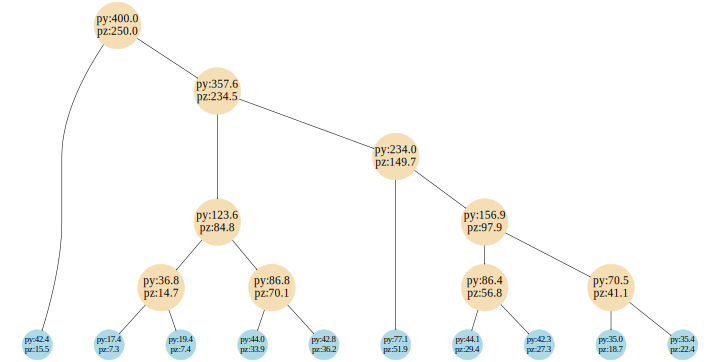

In [39]:
print('Greedy LH JET')
tree = Tree1D.plotBinaryTree(
    greedyLH, 
    label=True,
)
tree.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
# tree.render(filename="../ToyJetsShower/notes/plots/figTruth_jet9")
display(tree)

Leaves ordered according to truth jet - Greedy LH (top) vs TRUTH (bottom) trees


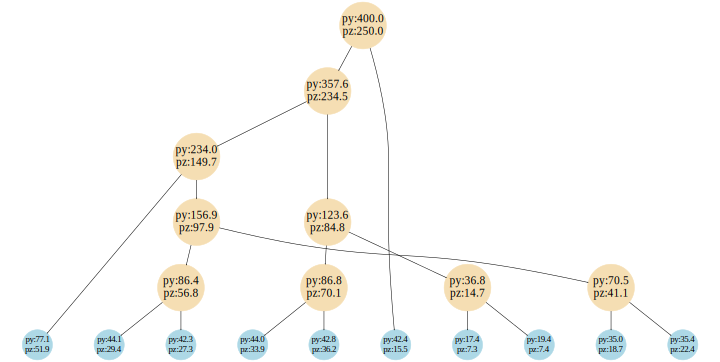

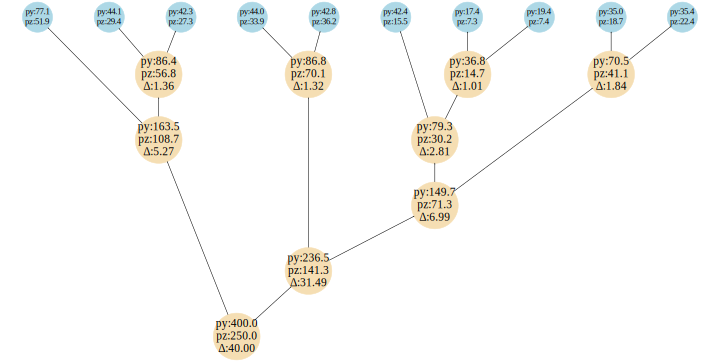

In [40]:
print("Leaves ordered according to truth jet - Greedy LH (top) vs TRUTH (bottom) trees")
tree1, tree2 = Tree1D.visualizeTreePair(
    greedyLH, 
    truth_jet,
    truthOrder = True,
    label = True,
)
tree1.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
tree2.attr(rankdir='BT', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
display(tree1)
display(tree2)

Leaves ordered according to greedyLH jet - CA (top) vs greedyLH (bottom) trees


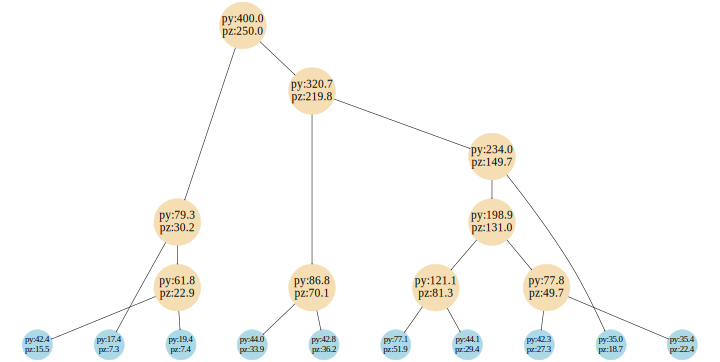

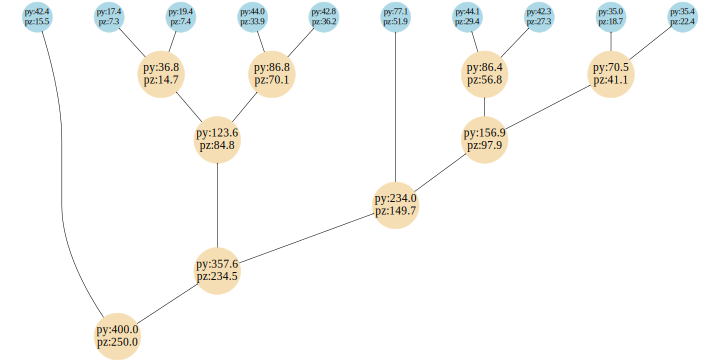

In [41]:
print("Leaves ordered according to greedyLH jet - CA (top) vs greedyLH (bottom) trees")
tree1, tree2 = Tree1D.visualizeTreePair(
    greedyLH, 
    reclusterCA,
    truthOrder = False,
    label = True,
    alpha_jet2 = 0,
)
tree1.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
tree2.attr(rankdir='BT', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
display(tree1)
display(tree2)

In [42]:
# print("Leaves ordered according to CA jet - greedyLH (top) vs CA (bottom) trees")
# tree1, tree2 = Tree1D.visualizeTreePair(reclusterCA, greedyLH, truthOrder=False, label=True, alpha_jet1= 0)
# tree1.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
# tree2.attr(rankdir='BT', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
# display(tree1)
# display(tree2)

## BEAM SEARCH VS GREEDY ALGORITHMS CROSS-CHECK 

The greedy algorithm should be a base case of the beam search. In particular they should be identical when the beam size is one.
We compare them for this case of beam size = 1 below and see that they give the same latent structure. 

In [43]:
beamSearch_jetsOne = beamSearch.recluster( 
    truth_jet, 
    beamSize = 1,
    delta_min =  truth_jet["pt_cut"],
    lam = truth_jet["Lambda"],
    N_best = 1,
)

In [44]:
beamSearch_jetsOne[0]["logLH"]

array([-1.89435005, -1.97229087,  0.4995904 , -1.98505843, -2.14269114,
       -0.30674982, -4.01851177, -3.96025705, -5.74352455])

In [45]:
greedyLH["logLH"]

array([-1.89435   , -1.9722909 ,  0.4995904 , -1.9850584 , -2.1426911 ,
       -0.30674982, -4.018512  , -3.960257  , -5.7435246 ], dtype=float32)

In [46]:
np.asarray(greedyLH["logLH"]) -  beamSearch_jetsOne[0]["logLH"]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

Leaves ordered according to greedyLH jet - Beam Search LH (top) vs greedyLH (bottom) trees


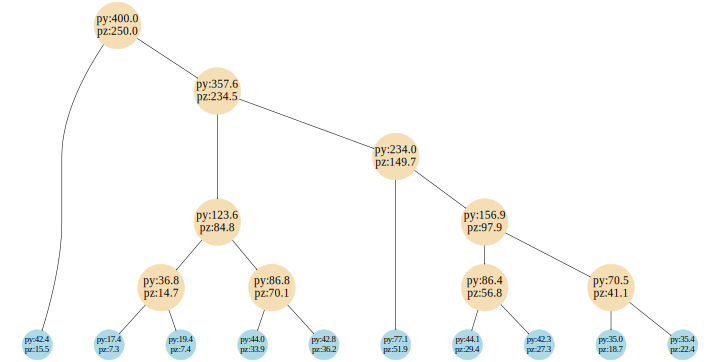

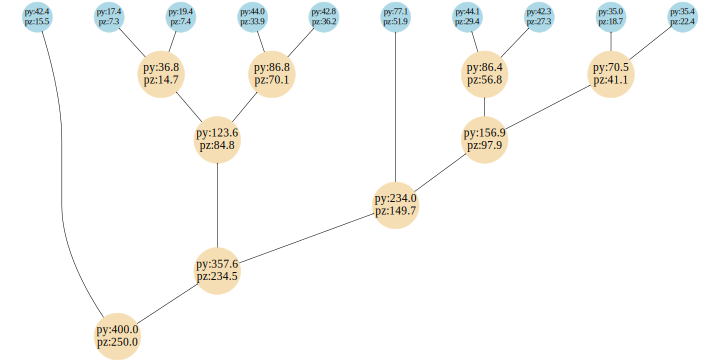

In [47]:
print("Leaves ordered according to greedyLH jet - Beam Search LH (top) vs greedyLH (bottom) trees")
tree1, tree2 = Tree1D.visualizeTreePair(
    greedyLH, 
    beamSearch_jetsOne[0],
    truthOrder = False, 
    label = True, 
    beamSize = 1,
    N_best = 1,
)
tree1.attr(rankdir='TB', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
tree2.attr(rankdir='BT', size="10",margin='0' ,ratio="0.5" , nodesep="0.01")
display(tree1)
display(tree2)

### The beam seach algorithm gives a greater jet log likelihood for a big enough beam size

In [48]:
beamSearch_jetsComp = beamSearch.recluster( 
    truth_jet, 
    beamSize = 45,
    delta_min =  truth_jet["pt_cut"],
    lam = truth_jet["Lambda"],
    N_best = 45,
)

In [49]:
# Beam search total log likelihood
np.sum(beamSearch_jetsComp[0]["logLH"])

-15.828511834144592

In [50]:
# truth jet total log likelihood
truth_logLH = np.sum(truth_jet["logLH"]) 
display(truth_logLH)

-16.83590602874756

In [51]:
# Greedy total log likelihood
np.sum(greedyLH["logLH"])

-21.523842